In [1]:
import pandas as pd
import numpy as np
import nltk
import glob
import io
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [2]:
contents = []
overalls = []
for filename in glob.iglob('./Review_Texts/*.dat', ):
#for filename in glob.iglob('./test_hotel/*.dat', ):
    with io.open(filename, 'r', encoding="utf8") as input_file:
        lines = input_file.readlines()
        
        for line in lines:
            #print(line)
            if '<Content>' in line:
                contents.append(line[9:].strip('\n'))
            if '<Overall>' in line:
                overalls.append(line[9:].strip('\n'))

In [3]:
df = pd.DataFrame(list(map(list, zip(contents, overalls))))
columns = ['review', 'score']
df.columns = columns
df.review = df.review.str.lower()

In [4]:
#Assume that negative reviews have 0-1 score and positive have 4-5 score
def filter(user):
    score = int(user)
    if (score <2):     
        return 'neg'
    elif (score >=2 and score <4):
        return 'neutral'
    else:
        return 'pos'
    

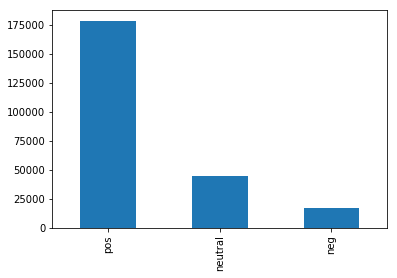

In [5]:
df['category'] = df['score'].apply(filter)

df.category.value_counts().plot(kind='bar')

In [ ]:
short_pos = df.review[df['category'] == 'pos']
short_pos = short_pos[:17000]
short_neg = df.review[df['category'] == 'neg']

In [ ]:
neg_df = pd.DataFrame(short_neg)
neg_df['label'] = 0

pos_df = pd.DataFrame(short_pos)
pos_df['label'] = 1

In [ ]:
from sklearn.utils import shuffle
new_df = pd.concat([neg_df, pos_df])

new_df = shuffle(new_df)

In [ ]:
from sklearn.model_selection import train_test_split
    
X = new_df['review'].values
y = new_df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df = 0.6,
                             stop_words='english',
                             use_idf=True)
X_train = vectorizer.fit_transform(X_train)
print("  Actual number of tfidf features: %d" % X_train.get_shape()[1])

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd = TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train)

explained_variance = svd.explained_variance_ratio_.sum()
print("  Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

In [ ]:
X_test = vectorizer.transform(X_test)
X_test_lsa = lsa.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
#from sklearn.metrics import mean_squared_error
#import math
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
rf = RandomForestClassifier(n_estimators=15)
rf.fit(X_train, y_train)
predicted = cross_val_predict(rf, X_test_lsa, y_test, cv=5)
metrics.accuracy_score(y_test, predicted) 

In [ ]:
import pickle
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

filename = 'RandomForest_model.sav'
pickle.dump(rf, open(filename, 'wb')) 

In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
cross_val_predict(loaded_model, X_test_lsa, y_test, cv=5)
metrics.accuracy_score(y_test, predicted) 